In [1]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
torch.set_num_threads(1)


# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * 0.25 * theta[2]
    return resultDtheta

def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
    logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        tmp = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))
        fitDerivError[:, vEachDim] -= tmp[:, 0]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
        # inverse of Cd
        CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    theta_lb = torch.clamp(theta[:, 2], min=0.)
#     theta_ub = torch.clamp(theta[:, 2], max=0.3)
    return torch.sum(res) - 1e6 * torch.sum(torch.square(theta[:, 2] - theta_lb))

def MaternKernel(d, phi_1, phi_2, nu=2.5):
    """
    construct a kernel given time points and hyper parameters
    """
    if nu == 2.5:  
        a = torch.square(phi_1) * (
                1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
            -np.sqrt(5) * d / phi_2)
        return a.double()
    else:
        a = torch.square(phi_1) * (1. + np.sqrt(3) * d / phi_2) * torch.exp(-np.sqrt(3) * d / phi_2)       
        return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb, phi2_lb, sigma_lb):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e8 * torch.square(phi_2 - phi_2_bounded) - 1e8 * torch.square(sigma - sigma_bounded)

def to_band(matrix, bandwidth):
    dim = matrix.shape[0]
    for i in range(dim):
        for j in range(dim):
            if i > j + bandwidth or i < j - bandwidth:
                matrix[i][j] = 0
    return matrix.to_sparse()

def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList, positive=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
        # inverse of Cd
        CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ torch.sparse.mm(KinvthetaList[thetaEachDim], (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]).reshape(-1, 1)))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    theta_lb = torch.clamp(theta[:, 2], min = 0.)
    return torch.sum(res) + torch.sum(res_theta)  - 1e6 * torch.sum(torch.square(theta[:, 2] - theta_lb))

In [2]:
use_data_idx = 0
days = 32
discretization = 2
obs_per_day = 1
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, 1., 1., 1.])
param_names = ['re', 've', 'vi', 'pd']
is_time_varying=[True, True, False, True]
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 100000, 15000, 100000]
phi1_lb_ls=np.array([2., 0.1, 0.1])
phi2_lb_ls=np.array([2., 2., 2.])
sigma_lb_ls = np.array([0.01, 0.01, 0.01])
bandwidth=20


observations = np.load('SEIRD observations.npy')
N = 100000.

In [3]:
yobs = observations[use_data_idx]
yobs[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = days * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])


# First stage: use MAGI package to optimize theta as constant #####################

time_1 = time.time()
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=bandwidth,
    useFrequencyBasedPrior=True,
    useBand=True,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
print(inferred_theta)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
MAGI_time = time.time() - time_1
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=to_band(torch.from_numpy(matrix(each_gpcov.Cinv)).double(),bandwidth=bandwidth), 
            Kinv=to_band(torch.from_numpy(matrix(each_gpcov.Kinv)).double(),bandwidth=bandwidth),
            mphi=to_band(torch.from_numpy(matrix(each_gpcov.mphi)).double(),bandwidth=bandwidth),
        )
        CovAllDimensionsPyList.append(each_pycov)

[1.87143191 0.10205595 0.0924365  0.19611035]


In [4]:
time_2 = time.time()
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
pointwise_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, pointwise_sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e12
LossVal = np.zeros(n_iter[1])
backward_time_ls = np.zeros(n_iter[1])
step_time_ls = np.zeros(n_iter[1])
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, pointwise_sigma_torch,
                                        TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    new_loss = -llik
    LossVal[epoch] = new_loss
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
#             if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
#                 break
        cur_loss = new_loss.item()
    time_b = time.time()
    new_loss.backward()
    backward_time_ls[epoch] = time.time() - time_b
    time_s = time.time()
    pointwise_optimizer.step()
    step_time_ls[epoch] = time.time() - time_s
    pointwise_lr_scheduler.step()


0 -33.46622826583106


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


200 -61.46563253865944
400 -65.46867597014563
600 -70.30719567185052
800 -75.8779406930725
1000 -82.14628031770047
1200 -89.11858788285758
1400 -96.83452296441611
1600 -105.37385043792555
1800 -114.86939955901603
2000 -125.52391045651167
2200 -137.63084675785728
2400 -151.57108526671408
2600 -167.36598236474424
2800 -182.12545914942248
3000 -191.45635228751482
3200 -197.9308097034147
3400 -203.6519816645105
3600 -209.0308313392814
3800 -214.26151423425827
4000 -219.5572896632014
4200 -225.18761975798978
4400 -231.55542682526388
4600 -238.9431599926636
4800 -245.99614954845265
5000 -251.6919028597476
5200 -256.94624629263217
5400 -262.0846765678946
5600 -267.20006527565323
5800 -272.33597765371474
6000 -277.5218352361838
6200 -282.7747847475248
6400 -288.0937203044424
6600 -293.4700904446499
6800 -298.88509143458487
7000 -304.37054876995614
7200 -309.98225229812874
7400 -315.72715841067986
7600 -321.2681428789656
7800 -326.0010593191453
8000 -329.78837822384327
8200 -332.74233223820045


In [ ]:
phi1_lb_ls=np.array([1., 0.1, 0.1])
phi2_lb_ls=np.array([5, 5, 5.])
sigma_lb_ls = np.array([0.01, 0.01, 0.01])

In [5]:
# Kernel estimation ########################################
time_3 = time.time()
pointwise_theta = pointwise_theta_torch.detach().numpy()
hyperparamList = []

# optimize the hyperparameters of kernels
for thetaEachDimension in range(pointwise_theta.shape[1]):
    phi_1 = torch.tensor(phi1_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
    phi_2 = torch.tensor(phi2_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
    sigma = torch.tensor(sigma_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
    kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
    kernel_backward_time = np.zeros(n_iter[2])
    kernel_step_time = np.zeros(n_iter[2])
    for epoch in range(n_iter[2]):
        kernel_optimizer.zero_grad()
        loss = -kernelllik(phi_1, 
                           phi_2, 
                           sigma, 
                           pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                           d_matrix, 
                           phi1_lb_ls[thetaEachDimension], 
                           phi2_lb_ls[thetaEachDimension],
                           sigma_lb_ls[thetaEachDimension])
        time0 = time.time()
        loss.backward()
        kernel_backward_time[epoch] = time.time() - time0
        time0 = time.time()
        kernel_optimizer.step()
        kernel_step_time[epoch] = time.time() - time0
        if epoch % 100 == 0:
            print(epoch, loss.item())
    print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()) 
    kernel_backward_time = np.mean(kernel_backward_time)
    kernel_step_time = np.mean(kernel_step_time)
    hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
    KinvthetaList.append(to_band(torch.inverse(ker), bandwidth = bandwidth))
kernel_total_time = time.time() - time_3

0 -17.045264437511406
100 -57.2654439289052
200 -57.27242347884419
300 -57.28138347798024
400 -57.29195530470518
500 -57.30396269686233
600 -57.31738500879
700 -57.332349364101844
800 -57.34915290256771
900 -57.368317875259876
1000 -57.390699468539935
1100 -57.417692022457416
1200 -57.451636201171624
1300 -57.49667337202453
1400 -57.56069997424096
1500 -57.66039803057788
1600 -57.836565957498394
1700 -58.21567291866501
1800 -59.49614532050225
1900 -58.96083492281923
2000 -62.35150660336815
2100 -63.74390692352637
2200 -63.998503001268176
2300 -66.85619200669004
2400 -71.11577783291844
2500 -71.59268937064996
2600 -70.98546062398373
2700 -73.34819020876114
2800 -68.81057515107771
2900 -73.42607005152757
3000 -73.41744352840105
3100 -73.50282694949593
3200 -72.72483850555945
3300 -72.09603762006438
3400 -73.5423100194126
3500 -72.99400527399011
3600 -71.94628328568733
3700 -73.35206709332266
3800 -73.2894271869855
3900 -73.427182663423
4000 -73.25782942425396
4100 -73.40019049277657
4200

In [6]:
# TVMAGI optimization #############################
time_4 = time.time()
TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(TVMAGI_optimizer, step_size=10000, gamma=0.9)
cur_loss = 1e12
TVMAGI_backward_time = np.zeros(n_iter[3])
TVMAGI_step_time = np.zeros(n_iter[3])
for epoch in range(n_iter[3]):
    TVMAGI_optimizer.zero_grad()
    # compute loss function
    llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)
    loss = -llik
    if epoch % 500 == 0:
        print(epoch, loss.item())
#             if torch.isnan(loss) == False and loss - cur_loss > -0.01 and loss - cur_loss < 0.01:
#                 break
        cur_loss = loss.item()
    time0 = time.time()
    loss.backward()
    TVMAGI_backward_time[epoch] = time.time() - time0
    time0 = time.time()
    TVMAGI_optimizer.step()
    TVMAGI_step_time[epoch] = time.time() - time0
    lr_scheduler.step()

0 8677.230300203548
500 7084.911684459861
1000 6270.923083552891
1500 5665.589692969606
2000 5164.096155352367
2500 4715.652201950382
3000 4302.933584259656
3500 3921.814829906526
4000 3568.710153949779
4500 3241.8668810882045
5000 2940.0549358827216
5500 2661.6977259807745
6000 2405.083298227235
6500 2168.5520248723847
7000 1950.3648716573725
7500 1748.4887628921792
8000 1561.6385105653337
8500 1388.933533214501
9000 1229.5811175378385
9500 1083.0008458897635
10000 950.1337724357802
10500 841.3051554523119
11000 741.8941711827061
11500 653.1821980256996
12000 578.6145971726423
12500 512.3954588960343
13000 451.00519409931206
13500 390.95631765684243
14000 332.2131911813717
14500 275.35171811231555
15000 220.8854070001292
15500 169.20559176325284
16000 120.49591427648546
16500 74.69214117482456
17000 31.711330057877564
17500 -8.38926895033383
18000 -45.4071632179195
18500 -79.01725194454148
19000 -108.90342643620296
19500 -135.12631003787277
20000 -158.41099195368233
20500 -176.9862259

KeyboardInterrupt: 

In [ ]:
KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(0.1), torch.tensor(8.))
    KinvthetaList.append(to_band(torch.inverse(ker), bandwidth = bandwidth))

In [7]:
def vectorize(xlatent, theta, sigma, time_constant_param_ls):
    t1 = torch.reshape(xlatent.detach(), (-1,))
    t2 = torch.reshape(theta.detach(), (-1,))
    t3 = torch.reshape(sigma.detach(), (-1,))
    long_vec = torch.cat((t1, t2, t3))
    for i in range(len(time_constant_param_ls)):
        long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
    return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim
    
def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim],xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim],theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim],sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls


def NegLogLikelihood(xlatent, theta, sigma, time_constant_param_ls, 
                     inferred_theta = inferred_theta, 
                     ydata = ydata, 
                     CovAllDimensionsPyList = CovAllDimensionsPyList, 
                     fOdeTorch = fOdeTorch,
                     priorTemperature = priorTemperature, 
                     KinvthetaList = KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
        # inverse of Cd
        CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ torch.sparse.mm(KinvthetaList[thetaEachDim], (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]).reshape(-1, 1))[:, 0])
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return -(torch.sum(res) + torch.sum(res_theta))

class HMC:
    def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, lsteps=50, epsilon=1e-5, n_samples=4000, upper_bound = None, lower_bound = None, burn_in_ratio = 0.5):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.lsteps = lsteps
        self.epsilon = epsilon * torch.ones(all_theta.shape)
        self.burn_in_ratio = burn_in_ratio
        self.n_samples = n_samples
        self.total_samples = int(n_samples / (1 - burn_in_ratio))
        self.NegLogLikelihood = negllik
        self.ub = upper_bound
        if upper_bound is not None:
            if upper_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
        self.lb = lower_bound
        if lower_bound is not None:
            if lower_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
    
    def NegLogLikelihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        return NegLogLikelihood(xlatent_0, theta_0, sigma_0, constant_param_ls_0)
    
    def Nabla(self, theta_torch):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True  
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True                      
        llik = self.NegLogLikelihood(xlatent, theta, sigma, constant_param_ls)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)

        return v
    def sample(self, all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)

        trace_val = np.zeros(self.total_samples)
        samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
        random_ls = np.random.uniform(0, 1, self.total_samples)
        acceptance_ls = np.zeros(self.total_samples)
        nan_ls = np.zeros(self.total_samples)
        cur_theta = self.all_theta.clone().detach()
        for EachIter in range(self.total_samples): ############
            cur_nllik_1 = self.NegLogLikelihood_vec(cur_theta).detach()
            rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
            p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
            cur_p = p.clone()
            theta = cur_theta.clone()         
            p = p - rstep * self.Nabla(theta).clone() / 2
            for i in range(self.lsteps):
                theta = theta + rstep * p
                nabla_torch = self.Nabla(theta).clone()
                p = p - rstep * nabla_torch
                theta = bounce(theta, self.lb, self.ub)
            
            p = p - rstep * self.Nabla(theta).clone() / 2
            
            new_nllik = self.NegLogLikelihood_vec(theta)
            new_p = 0.5 * torch.sum(torch.square(p))
            new_H = new_nllik + new_p
            cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
            cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
#             print(new_H, cur_H)
            
            if torch.isnan(theta[0]) or torch.isnan(new_H):
                samples[EachIter] = cur_theta.clone()
                nan_ls[EachIter] = 1
                self.epsilon *= 0.9
                print('NaN!')
            else:
                # accept
                tmp = float(torch.exp(cur_H - new_H))
#                 print(tmp)
                if  tmp > random_ls[EachIter]:
                    samples[EachIter] = theta.clone()
                    cur_theta = theta.clone()
                    acceptance_ls[EachIter] = 1
                # reject
                else:
                    samples[EachIter] = cur_theta.clone()
                    
            trace_val[EachIter] = self.NegLogLikelihood_vec(cur_theta).item()        

            if EachIter > 200 and EachIter < self.total_samples - self.n_samples:
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 60:
                    # decrease epsilon
                    self.epsilon *= 0.995
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 90:
                    # increase epsilon
                    self.epsilon *= 1.005
            if EachIter % 100 == 0 and EachIter > 100:
                print(EachIter)
                print(cur_nllik)
                print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                if EachIter < self.total_samples - self.n_samples:
                    standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                    if torch.mean(standard_deviation) > 1e-6:
                        self.epsilon = 0.05 * standard_deviation * torch.mean(self.epsilon) / torch.mean(standard_deviation) + 0.95 * self.epsilon
        return samples, acceptance_ls, trace_val, nan_ls # [self.total_samples-self.n_samples:, :]

all_theta_TVMAGI = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
# all_theta_true = vectorize(true_x_torch, theta_true_torch, TVMAGI_sigma_torch, time_constant_param_ls)
all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
sampler = HMC(NegLogLikelihood, all_theta_TVMAGI, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              TVMAGI_sigma_torch.shape,
              time_constant_param_ls, 
              lower_bound = torch.zeros(all_theta_pointwise.shape))
# sampler.Nabla(all_theta)
# lower_bound = torch.zeros(all_theta_pointwise.shape)
samples, b, c, d = sampler.sample(all_theta_TVMAGI, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList)

200
tensor(-153.0684, dtype=torch.float64)
acceptance rate:  0.67
300
tensor(-147.8625, dtype=torch.float64)
acceptance rate:  0.79
400
tensor(-134.8585, dtype=torch.float64)
acceptance rate:  0.75
500
tensor(-137.8189, dtype=torch.float64)
acceptance rate:  0.73
600
tensor(-126.2097, dtype=torch.float64)
acceptance rate:  0.63
700
tensor(-136.0552, dtype=torch.float64)
acceptance rate:  0.75
800
tensor(-135.9073, dtype=torch.float64)
acceptance rate:  0.75
900
tensor(-121.8453, dtype=torch.float64)
acceptance rate:  0.76
1000
tensor(-120.1046, dtype=torch.float64)
acceptance rate:  0.71
1100
tensor(-137.5219, dtype=torch.float64)
acceptance rate:  0.76
1200
tensor(-130.1501, dtype=torch.float64)
acceptance rate:  0.79
1300
tensor(-119.6414, dtype=torch.float64)
acceptance rate:  0.77
1400
tensor(-84.6482, dtype=torch.float64)
acceptance rate:  0.79
1500
tensor(-134.1069, dtype=torch.float64)
acceptance rate:  0.77
1600
tensor(-113.1810, dtype=torch.float64)
acceptance rate:  0.74
1700

Text(0.5, 1.0, '$p^d$ - trained hyperparameter')

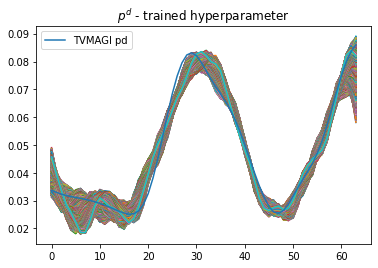

In [11]:
TVMAGI_theta = TVMAGI_theta_torch.detach().numpy()
k = samples[4000:, 256:256+192]
val = np.zeros((64, 3))
for i in range(4000):
    for j in range(64):
        val[j] = k[i].reshape(-1, 3)[j]
    plt.plot(val[:, 0])
plt.plot(TVMAGI_theta[:, 0], label='TVMAGI beta')
# plt.plot(np.arange(0, 64, 2), true_ve, label='true')
plt.legend()
plt.title(r'$\beta$ - trained hyperparameter')


In [13]:
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]
T = 2
tmp = np.linspace(0, 2 * T * np.pi, 64)
true_beta = parameter_value[0] - std[0] * np.cos(tmp)
true_ve = parameter_value[1]- std[1] * np.cos(tmp)
true_vi = parameter_value[2] 
true_pd = parameter_value[3] + std[3] * np.cos(tmp)

Text(10, 0.06, '%=0.5625')

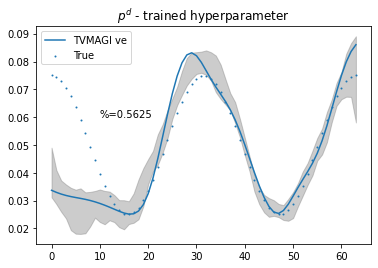

In [49]:
TVMAGI_theta = TVMAGI_theta_torch.detach().numpy()
k = samples[4000:, 256:256+192]
beta_ls = np.zeros((4000, 64))

for i in range(4000):
    for j in range(64):
        val[j] = k[i].reshape(-1, 3)[j]
    beta_ls[i] = val[:, 2]/4
    
max_beta = np.amax(beta_ls, axis = 0)
min_beta = np.min(beta_ls, axis = 0)
plt.plot(TVMAGI_theta[:, 2]/4, label='TVMAGI ve')
# plt.plot(min_beta, label='min beta')
# plt.plot(max_beta, label='max beta')
# lower_95 = np.percentile(beta_ls, 100, axis=0)
# upper_95 = np.percentile(all_ve, 0, axis=0)
plt.fill_between(np.arange(0, 64, 1), min_beta, max_beta, color='grey', alpha = 0.4)
plt.scatter(np.arange(0, 64, 1), true_pd, label='True', s=1)
# plt.plot(np.arange(0, 64, 2), true_ve, label='true')
plt.legend()
plt.title(r'$p^d$ - trained hyperparameter')
plt.text(10, 0.06, '%=0.5625')

In [47]:
np.sum(np.minimum(true_pd <= max_beta, true_pd >= min_beta)) / 64

0.5625

# TVMAGI with HMC

In [1]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi, matrix
import time
import pickle
import matplotlib.pyplot as plt
torch.set_num_threads(1)


# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * 0.25 * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * 0.25 * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * 0.25 * theta[2]
    return resultDtheta

def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
    logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
    # reparametrize on pd
    logDdt = torch.exp(logI - logD) * 0.25 * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature, obs_per_day, positive_param=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        tmp = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))
        fitDerivError[:, vEachDim] -= tmp[:, 0]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
        # inverse of Cd
        CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    theta_lb = torch.clamp(theta[:, 2], min=0.)
#     theta_ub = torch.clamp(theta[:, 2], max=0.3)
    return torch.sum(res) - 1e6 * torch.sum(torch.square(theta[:, 2] - theta_lb))

def MaternKernel(d, phi_1, phi_2, nu=2.5):
    """
    construct a kernel given time points and hyper parameters
    """
    if nu == 2.5:  
        a = torch.square(phi_1) * (
                1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
            -np.sqrt(5) * d / phi_2)
        return a.double()
    else:
        a = torch.square(phi_1) * (1. + np.sqrt(3) * d / phi_2) * torch.exp(-np.sqrt(3) * d / phi_2)       
        return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb, phi2_lb, sigma_lb):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e8 * torch.square(phi_2 - phi_2_bounded) - 1e8 * torch.square(sigma - sigma_bounded)

def to_band(matrix, bandwidth):
    dim = matrix.shape[0]
    for i in range(dim):
        for j in range(dim):
            if i > j + bandwidth or i < j - bandwidth:
                matrix[i][j] = 0
    return matrix.to_sparse()

def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList, positive=True):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
        # inverse of Cd
        CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ torch.sparse.mm(KinvthetaList[thetaEachDim], (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]).reshape(-1, 1)))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    theta_lb = torch.clamp(theta[:, 2], min = 0.)
    return torch.sum(res) + torch.sum(res_theta)  - 1e6 * torch.sum(torch.square(theta[:, 2] - theta_lb))



def vectorize(xlatent, theta, sigma, time_constant_param_ls):
    t1 = torch.reshape(xlatent.detach(), (-1,))
    t2 = torch.reshape(theta.detach(), (-1,))
    t3 = torch.reshape(sigma.detach(), (-1,))
    long_vec = torch.cat((t1, t2, t3))
    for i in range(len(time_constant_param_ls)):
        long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
    return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim
    
def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim],xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim],theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim],sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls

    
    

def TVMAGI_sampler(use_data_idx = 0,
                    days = 32,
                    discretization = 2,
                    obs_per_day = 1,
                    theta_lowerbound=np.array([0., 0., 0., 0.]),
                    theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                    param_names = ['re', 've', 'vi', 'pd'],
                    is_time_varying=[True, True, False, True],
                    use_trajectory='inferred',
                    learning_rate=np.array([1e-4, 1e-3, 1e-5]),
                    n_iter = [15001, 100000, 15000, 100000],
                    phi1_lb_ls=np.array([2., 0.1, 0.1]),
                    phi2_lb_ls=np.array([2., 2., 2.]),
                    sigma_lb_ls = np.array([0.01, 0.01, 0.01]),
                    bandwidth=20):
 
    
    
    
    
    yobs = observations[use_data_idx]
    yobs[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
    start_time = time.time()
    nobs, p_dim = yobs.shape[0], yobs.shape[1]
    n_points = days * discretization
    theta_dim = theta_lowerbound.shape[0]
    d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
    for i in range(n_points):
        for j in range(n_points):
            if i > j:
                d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
            else:
                d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
    Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                             thetaLowerBound=theta_lowerbound,
                             thetaUpperBound=theta_upperbound)
    tvecObs = np.arange(0, days, 1. / obs_per_day)
    tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
    yFull = np.ndarray([n_points, p_dim])
    yFull.fill(np.nan)
    yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
    xInitExogenous = np.zeros_like(yFull)
    # interpolate: find the ydata of tvecFull given observations
    for i in range(p_dim):
        xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])


    # First stage: use MAGI package to optimize theta as constant #####################

    time_1 = time.time()
    result = solve_magi(
        yFull,
        Ode_system,
        tvecFull,
        sigmaExogenous=np.array([]),
        phiExogenous=np.array([[]]),
        xInitExogenous=xInitExogenous,
        thetaInitExogenous=np.array([]),
        muExogenous=np.array([[]]),
        dotmuExogenous=np.array([[]]),
        priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
        priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
        priorTemperatureObs=1.0,
        kernel="generalMatern",
        nstepsHmc=100,
        burninRatioHmc=0.5,
        niterHmc=n_iter[0],
        stepSizeFactorHmc=0.01,
        nEpoch=1,
        bandSize=bandwidth,
        useFrequencyBasedPrior=True,
        useBand=True,
        useMean=False,
        useScalerSigma=False,
        useFixedSigma=False,
        verbose=True)
    samplesCpp = result['samplesCpp']
    llikId = 0
    xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
    # dimension of theta
    thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
    sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
    burnin = int(n_iter[0] * 0.5)
    xsampled = samplesCpp[xId, (burnin + 1):]
    xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
    CovAllDimensionsPyList = []
    thetaSampled = samplesCpp[thetaId, (burnin + 1):]
    inferred_theta = np.mean(thetaSampled, axis=-1)
    print(inferred_theta)
    sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
    inferred_sigma = np.mean(sigmaSampled, axis=-1)
    inferred_trajectory = np.mean(xsampled, axis=-1)
    MAGI_time = time.time() - time_1
    for each_gpcov in result['result_solved'].covAllDimensions:
            each_pycov = dict(
                Cinv=to_band(torch.from_numpy(matrix(each_gpcov.Cinv)).double(),bandwidth=bandwidth), 
                Kinv=to_band(torch.from_numpy(matrix(each_gpcov.Kinv)).double(),bandwidth=bandwidth),
                mphi=to_band(torch.from_numpy(matrix(each_gpcov.mphi)).double(),bandwidth=bandwidth),
            )
            CovAllDimensionsPyList.append(each_pycov)
            
    # Pointwise optimization #############################################
    time_2 = time.time()
    TV_theta_mean = np.zeros(int(sum(is_time_varying)))
    tv_index = 0
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == True:
            TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
            tv_index += 1

    if use_trajectory == 'observation':
        pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
    elif use_trajectory == 'inferred':
        pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
    else:
        raise ValueError
    tmp1 = np.array([TV_theta_mean])
    initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
    pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
    pointwise_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == 0:
            param_name = param_names[thetaEachDim]
            locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
            time_constant_param_ls.append(eval(param_name))

    ydata = torch.from_numpy(yFull).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
    pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, pointwise_sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
    pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
    cur_loss = 1e12
    LossVal = np.zeros(n_iter[1])
    backward_time_ls = np.zeros(n_iter[1])
    step_time_ls = np.zeros(n_iter[1])
    for epoch in range(n_iter[1]):
        pointwise_optimizer.zero_grad()
        # compute loss function
        llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, pointwise_sigma_torch,
                                            TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day)
        new_loss = -llik
        LossVal[epoch] = new_loss
        if epoch % 200 == 0:
            print(epoch, new_loss.item())
            diff = new_loss.item() - cur_loss
    #             if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
    #                 break
            cur_loss = new_loss.item()
        time_b = time.time()
        new_loss.backward()
        backward_time_ls[epoch] = time.time() - time_b
        time_s = time.time()
        pointwise_optimizer.step()
        step_time_ls[epoch] = time.time() - time_s
        pointwise_lr_scheduler.step()
        
    
    # Kernel estimation ########################################
    time_3 = time.time()
    pointwise_theta = pointwise_theta_torch.detach().numpy()
    hyperparamList = []

    # optimize the hyperparameters of kernels
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        phi_1 = torch.tensor(phi1_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
        phi_2 = torch.tensor(phi2_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
        sigma = torch.tensor(sigma_lb_ls[thetaEachDimension], requires_grad=True, dtype=torch.double)
        kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
        kernel_backward_time = np.zeros(n_iter[2])
        kernel_step_time = np.zeros(n_iter[2])
        for epoch in range(n_iter[2]):
            kernel_optimizer.zero_grad()
            loss = -kernelllik(phi_1, 
                               phi_2, 
                               sigma, 
                               pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                               d_matrix, 
                               phi1_lb_ls[thetaEachDimension], 
                               phi2_lb_ls[thetaEachDimension],
                               sigma_lb_ls[thetaEachDimension])
            time0 = time.time()
            loss.backward()
            kernel_backward_time[epoch] = time.time() - time0
            time0 = time.time()
            kernel_optimizer.step()
            kernel_step_time[epoch] = time.time() - time0
            if epoch % 100 == 0:
                print(epoch, loss.item())
        print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()) 
        kernel_backward_time = np.mean(kernel_backward_time)
        kernel_step_time = np.mean(kernel_step_time)
        hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

    KinvthetaList = []
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
        KinvthetaList.append(to_band(torch.inverse(ker), bandwidth = bandwidth))
    kernel_total_time = time.time() - time_3            
            
    # TVMAGI optimization #############################        
    time_4 = time.time()
    TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
    TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
    TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(TVMAGI_optimizer, step_size=10000, gamma=0.9)
    cur_loss = 1e12
    TVMAGI_backward_time = np.zeros(n_iter[3])
    TVMAGI_step_time = np.zeros(n_iter[3])
    for epoch in range(n_iter[3]):
        TVMAGI_optimizer.zero_grad()
        # compute loss function
        llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                    TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                    priorTemperature, KinvthetaList)
        loss = -llik
        if epoch % 500 == 0:
            print(epoch, loss.item())
    #             if torch.isnan(loss) == False and loss - cur_loss > -0.01 and loss - cur_loss < 0.01:
    #                 break
            cur_loss = loss.item()
        time0 = time.time()
        loss.backward()
        TVMAGI_backward_time[epoch] = time.time() - time0
        time0 = time.time()
        TVMAGI_optimizer.step()
        TVMAGI_step_time[epoch] = time.time() - time0
        lr_scheduler.step() 

    # TVMAGI sampler #######################################
    def NegLogLikelihood(xlatent, theta, sigma, time_constant_param_ls, 
                         inferred_theta = inferred_theta, 
                         ydata = ydata, 
                         CovAllDimensionsPyList = CovAllDimensionsPyList, 
                         fOdeTorch = fOdeTorch,
                         priorTemperature = priorTemperature, 
                         KinvthetaList = KinvthetaList):
        # length of observed y (t)
        n = ydata.shape[0]
        pdimension = ydata.shape[1]
        thetadimension = theta.shape[1]
        sigmaSq = torch.pow(sigma, 2)
        fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
        res = torch.zeros([pdimension, 3]).double()
        res_theta = torch.zeros(thetadimension).double()
        fitDerivError = torch.zeros([n, pdimension]).double()
        nobs = torch.zeros([pdimension]).double()
        fitLevelErrorSumSq = torch.zeros([pdimension]).double()
        for vEachDim in range(pdimension):
            fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
            fitDerivError[:, vEachDim] -= torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['mphi'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
            nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
            obsIdx = torch.isfinite(ydata[:, vEachDim])
            fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
        res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
        res[:, 0] /= priorTemperature[2]
        KinvfitDerivError = torch.zeros([n, pdimension]).double()
        CinvX = torch.zeros([n, pdimension]).double()
        for vEachDim in range(pdimension):
            # inverse of K
            KinvfitDerivError[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Kinv'], fitDerivError[:, vEachDim].reshape(-1, 1))[:, 0]
            # inverse of Cd
            CinvX[:, vEachDim] = torch.sparse.mm(CovAllDimensionsPyList[vEachDim]['Cinv'], xlatent[:, vEachDim].reshape(-1, 1))[:, 0]
        for thetaEachDim in range(thetadimension):
            res_theta[thetaEachDim] = -0.5 * torch.sum(
                (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ torch.sparse.mm(KinvthetaList[thetaEachDim], (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]).reshape(-1, 1))[:, 0])
        res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
        res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

        return -(torch.sum(res) + torch.sum(res_theta))

    class HMC:
        def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, lsteps=50, epsilon=1e-5, n_samples=4000, upper_bound = None, lower_bound = None, burn_in_ratio = 0.5):
            self.all_theta = all_theta
            self.theta_shape = theta_shape
            self.xlatent_shape = xlatent_shape
            self.sigma_shape = sigma_shape
            self.constant_dim = len(time_constant_param_ls)
            self.lsteps = lsteps
            self.epsilon = epsilon * torch.ones(all_theta.shape)
            self.burn_in_ratio = burn_in_ratio
            self.n_samples = n_samples
            self.total_samples = int(n_samples / (1 - burn_in_ratio))
            self.NegLogLikelihood = negllik
            self.ub = upper_bound
            if upper_bound is not None:
                if upper_bound.shape[0] != all_theta.shape[0]:
                    raise ValueError
            self.lb = lower_bound
            if lower_bound is not None:
                if lower_bound.shape[0] != all_theta.shape[0]:
                    raise ValueError

        def NegLogLikelihood_vec(self, all_theta):
            xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
            return NegLogLikelihood(xlatent_0, theta_0, sigma_0, constant_param_ls_0)

        def Nabla(self, theta_torch):
            theta_torch = theta_torch.detach()
            xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
            xlatent.requires_grad = True  
            theta.requires_grad = True
            sigma.requires_grad = True
            for each in constant_param_ls:
                each.requires_grad = True                      
            llik = self.NegLogLikelihood(xlatent, theta, sigma, constant_param_ls)
            llik.backward()
            constant_param_deriv_ls = []
            for each in constant_param_ls:
                constant_param_deriv_ls.append(each.grad)
            v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)

            return v
        def sample(self, all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList):
            def bounce(m, lb, ub):
                if lb is None and ub is None:
                    return m
                if lb is None:
                    max_tensor = torch.clamp(m - ub, min=0)
                    return m - 2 * max_tensor
                if ub is None:
                    min_tensor = torch.clamp(lb - m, min=0)
                    return m + 2 * min_tensor
                if torch.sum(lb < ub) < m.shape[0]:
                    raise ValueError
                if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                    return m
                if torch.sum(m >= lb) < m.shape[0]:
                    min_tensor = torch.clamp(lb - m, min=0)
                    return bounce(m + 2 * min_tensor, lb, ub)
                if torch.sum(m <= ub) < m.shape[0]:
                    max_tensor = torch.clamp(m - ub, min=0)
                    return bounce(m - 2 * max_tensor, lb, ub)

            trace_val = np.zeros(self.total_samples)
            samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
            random_ls = np.random.uniform(0, 1, self.total_samples)
            acceptance_ls = np.zeros(self.total_samples)
            nan_ls = np.zeros(self.total_samples)
            cur_theta = self.all_theta.clone().detach()
            for EachIter in range(self.total_samples): ############
                cur_nllik_1 = self.NegLogLikelihood_vec(cur_theta).detach()
                rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
                p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
                cur_p = p.clone()
                theta = cur_theta.clone()         
                p = p - rstep * self.Nabla(theta).clone() / 2
                for i in range(self.lsteps):
                    theta = theta + rstep * p
                    nabla_torch = self.Nabla(theta).clone()
                    p = p - rstep * nabla_torch
                    theta = bounce(theta, self.lb, self.ub)

                p = p - rstep * self.Nabla(theta).clone() / 2

                new_nllik = self.NegLogLikelihood_vec(theta)
                new_p = 0.5 * torch.sum(torch.square(p))
                new_H = new_nllik + new_p
                cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
                cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
    #             print(new_H, cur_H)

                if torch.isnan(theta[0]) or torch.isnan(new_H):
                    samples[EachIter] = cur_theta.clone()
                    nan_ls[EachIter] = 1
                    self.epsilon *= 0.9
                    print('NaN!')
                else:
                    # accept
                    tmp = float(torch.exp(cur_H - new_H))
    #                 print(tmp)
                    if  tmp > random_ls[EachIter]:
                        samples[EachIter] = theta.clone()
                        cur_theta = theta.clone()
                        acceptance_ls[EachIter] = 1
                    # reject
                    else:
                        samples[EachIter] = cur_theta.clone()

                trace_val[EachIter] = self.NegLogLikelihood_vec(cur_theta).item()        

                if EachIter > 200 and EachIter < self.total_samples - self.n_samples:
                    if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 60:
                        # decrease epsilon
                        self.epsilon *= 0.995
                    if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 80:
                        # increase epsilon
                        self.epsilon *= 1.005
                if EachIter % 100 == 0 and EachIter > 100:
                    print(EachIter)
                    print(cur_nllik)
                    print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                    if EachIter < self.total_samples - self.n_samples:
                        standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                        if torch.mean(standard_deviation) > 1e-6:
                            self.epsilon = 0.05 * standard_deviation * torch.mean(self.epsilon) / torch.mean(standard_deviation) + 0.95 * self.epsilon
            return samples, acceptance_ls, trace_val, nan_ls # [self.total_samples-self.n_samples:, :]
        
        
        
    all_theta_TVMAGI = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
    all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
    sampler = HMC(NegLogLikelihood, all_theta_TVMAGI, 
                  pointwise_xlatent_torch.shape,
                  pointwise_theta_torch.shape, 
                  TVMAGI_sigma_torch.shape,
                  time_constant_param_ls, 
                  lower_bound = torch.zeros(all_theta_pointwise.shape))
    # sampler.Nabla(all_theta)
    # lower_bound = torch.zeros(all_theta_pointwise.shape)
    samples, b, c, d = sampler.sample(all_theta_TVMAGI, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList)
    np.save('samples_' + str(use_data_idx) + '.npy', samples)
    return samples


from multiprocessing import Pool

if __name__ ==  '__main__': 
    observations = np.load('SEIRD observations.npy')
    N = 100000.
    pool = Pool(processes=1)
    results = pool.map(TVMAGI_sampler, range(1))
    pool.close()
    pool.join()



[1.87143191 0.10205595 0.0924365  0.19611035]
0 -33.46622826583106


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


200 -61.46563253865944
400 -65.46867597014563
600 -70.30719567185052
800 -75.8779406930725
1000 -82.14628031770047
1200 -89.11858788285758
1400 -96.83452296441611
1600 -105.37385043792555
1800 -114.86939955901603
2000 -125.52391045651167
2200 -137.63084675785728
2400 -151.57108526671408
2600 -167.36598236474424
2800 -182.12545914942248
3000 -191.45635228751482
3200 -197.9308097034147
3400 -203.6519816645105
3600 -209.0308313392814
3800 -214.26151423425827
4000 -219.5572896632014
4200 -225.18761975798978
4400 -231.55542682526388
4600 -238.9431599926636
4800 -245.99614954845265
5000 -251.6919028597476
5200 -256.94624629263217
5400 -262.0846765678946
5600 -267.20006527565323
5800 -272.33597765371474
6000 -277.5218352361838
6200 -282.7747847475248
6400 -288.0937203044424
6600 -293.4700904446499
6800 -298.88509143458487
7000 -304.37054876995614
7200 -309.98225229812874
7400 -315.72715841067986
7600 -321.2681428789656
7800 -326.0010593191453
8000 -329.78837822384327
8200 -332.74233223820045


In [2]:
k = samples[4000:, 256:256+192]
beta_ls = np.zeros((4000, 64))

for i in range(4000):
    for j in range(64):
        val[j] = k[i].reshape(-1, 3)[j]
    beta_ls[i] = val[:, 2]/4
    
max_beta = np.amax(beta_ls, axis = 0)
min_beta = np.min(beta_ls, axis = 0)
plt.plot(TVMAGI_theta[:, 2]/4, label='TVMAGI ve')
# plt.plot(min_beta, label='min beta')
# plt.plot(max_beta, label='max beta')
# lower_95 = np.percentile(beta_ls, 100, axis=0)
# upper_95 = np.percentile(all_ve, 0, axis=0)
plt.fill_between(np.arange(0, 64, 1), min_beta, max_beta, color='grey', alpha = 0.4)
plt.scatter(np.arange(0, 64, 1), true_pd, label='True', s=1)
# plt.plot(np.arange(0, 64, 2), true_ve, label='true')
plt.legend()
plt.title(r'$p^d$ - trained hyperparameter')
plt.text(10, 0.06, '%=0.5625')

NameError: name 'samples' is not defined